# 5-1, Dataset和DataLoader

Pytorch通常使用Dataset和DataLoader这两个工具类来构建数据管道。

Dataset定义了数据集的内容，它相当于一个类似列表的数据结构，具有确定的长度，能够用索引获取数据集中的元素。

而DataLoader定义了按batch加载数据集的方法，它是一个实现了`__iter__`方法的可迭代对象，每次迭代输出一个batch的数据。

DataLoader能够控制batch的大小，batch中元素的采样方法，以及将batch结果整理成模型所需输入形式的方法，并且能够使用多进程读取数据。

在绝大部分情况下，用户只需实现Dataset的`__len__`方法和`__getitem__`方法，就可以轻松构建自己的数据集，并用默认数据管道进行加载。




In [105]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

1.10.0
0.11.1


### 一，深入理解Dataset和DataLoader原理

#### **1，获取一个batch数据的步骤**

让我们考虑一下从一个数据集中获取一个batch的数据需要哪些步骤。

(假定数据集的特征和标签分别表示为张量`X`和`Y`，数据集可以表示为`(X,Y)`, 假定batch大小为`m`)

1，首先我们要确定数据集的长度`n`。

结果类似：`n = 1000`。

2，然后我们从`0`到`n-1`的范围中抽样出`m`个数(batch大小)。

假定`m=4`, 拿到的结果是一个列表，类似：`indices = [1,4,8,9]`

3，接着我们从数据集中去取这`m`个数对应下标的元素。

拿到的结果是一个元组列表，类似：`samples = [(X[1],Y[1]),(X[4],Y[4]),(X[8],Y[8]),(X[9],Y[9])]`

4，最后我们将结果整理成两个张量作为输出。

拿到的结果是两个张量，类似`batch = (features,labels) `， 

其中 `features = torch.stack([X[1],X[4],X[8],X[9]])`

`labels = torch.stack([Y[1],Y[4],Y[8],Y[9]])`


#### **2，Dataset和DataLoader的功能分工**

上述第1个步骤确定数据集的长度是由 Dataset的`__len__` 方法实现的。

第2个步骤从`0`到`n-1`的范围中抽样出`m`个数的方法是由 DataLoader的 `sampler`和 `batch_sampler`参数指定的。

`sampler`参数指定单个元素抽样方法，一般无需用户设置，程序默认在DataLoader的参数`shuffle=True`时采用随机抽样，`shuffle=False`时采用顺序抽样。

`batch_sampler`参数将多个抽样的元素整理成一个列表，一般无需用户设置，默认方法在DataLoader的参数`drop_last=True`时会丢弃数据集最后一个长度不能被batch大小整除的批次，在`drop_last=False`时保留最后一个批次。

第3个步骤的核心逻辑根据下标取数据集中的元素 是由 Dataset的 `__getitem__`方法实现的。

第4个步骤的逻辑由DataLoader的参数`collate_fn`指定。一般情况下也无需用户设置。


Dataset和DataLoader的一般使用方式如下：

In [106]:
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.utils.data import RandomSampler, BatchSampler

ds = TensorDataset(
    torch.randn(64, 3),
    torch.randint(0, 2, (64,)).float()
) 
dl = DataLoader(ds, batch_size=4, shuffle=True)
features, labels = next(iter(dl))
features, labels

(tensor([[-0.1576, -1.5980,  1.4208],
         [ 0.1181,  0.0234, -0.8952],
         [ 1.1929,  0.9050, -0.3248],
         [ 0.3785, -1.7803, -0.8380]]),
 tensor([1., 1., 1., 1.]))

将DataLoader内部调用方式步骤拆解如下：

In [107]:
from pprint import pprint

# step1: get dataset
ds = TensorDataset(
    torch.randn(64, 3),
    torch.randint(0, 2, (64,)).float()
) 
print(f"len(ds): {len(ds)}")

# step2: get indices related to samples for batch（realized by Sampler and BatchSampler in DataLoader）
random_sample = RandomSampler(ds)
batch_sampler = BatchSampler(random_sample, batch_size=4, drop_last=False)
for indices in batch_sampler:
    print(f"indices: {indices}")
    break

# step3: get batch according to indices(realized by __getitem__ in Dataset)
batch = [ds[i] for i in indices]
pprint(f'batch: {batch}', width=70)

# step4: shape batch into features, labels(realized by collate_fn in DataLoader)
def collate_fn(batch):
    features = torch.stack([i[0] for i in batch])
    labels = torch.stack([i[1] for i in batch])
    return features, labels

collate_fn(batch)


len(ds): 64
indices: [44, 6, 54, 18]
('batch: [(tensor([-0.1825,  0.6477,  0.2107]), tensor(0.)), '
 '(tensor([-2.0693, -0.8938,  0.3966]), tensor(1.)), (tensor([ '
 '0.0654, -0.1331, -0.7599]), tensor(1.)), (tensor([-0.0441,  '
 '0.2162,  1.5700]), tensor(1.))]')


(tensor([[-0.1825,  0.6477,  0.2107],
         [-2.0693, -0.8938,  0.3966],
         [ 0.0654, -0.1331, -0.7599],
         [-0.0441,  0.2162,  1.5700]]),
 tensor([0., 1., 1., 1.]))

#### **3，Dataset和DataLoader的核心源码**

以下是 Dataset和 DataLoader的核心源码，省略了为了提升性能而引入的诸如多进程读取数据相关的代码。


In [108]:
import torch

class Dataset():
    def __init__(self):
        pass
    
    def __len__(self):
        raise NotImplementedError
    
    def __getitem__(self, index):
        raise NotImplementedError

    
class DataLoader():
    def __init__(self, dataset, batch_size, collate_fn=None, shuffle=False, drop_last=False):
        self.dataset = dataset
        self.collate_fn = collate_fn if collate_fn else torch.utils.data._utils.collate.default_collate
        self.sampler = torch.utils.data.RandomSampler if shuffle else torch.utils.data.SequentialSampler
        self.batch_sampler = torch.utils.data.BatchSampler
        self.sample_iter = self.batch_sampler(self.sampler(self.dataset), batch_size=batch_size, drop_last=drop_last)
        
    def __next__(self):
        indices = next(iter(self.sample_iter))
        batch = self.collate_fn([self.dataset[i] for i in indices])
        return batch
    
    def __iter__(self):
        return self

测试：

In [109]:
from typing import Tuple


class ToyDataset(Dataset):
    def __init__(self, x, y) -> None:
        self.x = x
        self.y = y
    
    def __len__(self) -> int:
        return len(self.x)
    
    def __getitem__(self, index: int) -> Tuple[torch.tensor, torch.tensor]:
        return self.x[index], self.y[index]


X, y = torch.randn(64, 3), torch.randint(0, 2, (64,)).float()
ds = ToyDataset(X, y)
dl = DataLoader(ds, batch_size=4, shuffle=True)
next(dl)

[tensor([[ 1.3757, -2.4243, -1.3742],
         [ 0.9307, -0.1798, -1.6474],
         [-1.0072,  2.5417,  1.0479],
         [-2.5069,  0.2310, -2.3689]]),
 tensor([1., 1., 0., 0.])]

### 二，使用Dataset创建数据集

Dataset创建数据集常用的方法有：

* 使用 torch.utils.data.TensorDataset 根据Tensor创建数据集(numpy的array，Pandas的DataFrame需要先转换成Tensor)。

* 使用 torchvision.datasets.ImageFolder 根据图片目录创建图片数据集。

* 继承 torch.utils.data.Dataset 创建自定义数据集。


此外，还可以通过

* torch.utils.data.random_split 将一个数据集分割成多份，常用于分割训练集，验证集和测试集。

* 调用Dataset的加法运算符(`+`)将多个数据集合并成一个数据集。


#### **1，根据Tensor创建数据集**

In [110]:
# create dataset according to Tensor
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split


from sklearn import datasets
iris = datasets.load_iris()
# print(iris)
print(iris.keys())
ds = TensorDataset(torch.tensor(iris.data), torch.tensor(iris.target))
print(f"all sample number: {len(ds)}")

# 分割成训练集、测试集
n_train = int(len(ds) * 0.8)
n_val = len(ds) - n_train
train_ds, val_ds = random_split(ds, [n_train, n_val]) # parameters: dataset, [int, int]
len(train_ds), len(val_ds)


dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
all sample number: 150


(120, 30)

In [111]:

dl_train, dl_val = DataLoader(train_ds, batch_size=4, shuffle=True), DataLoader(val_ds, batch_size=4, shuffle=False)
# next(iter(dl_train)) 
for features, labels in dl_train:
    print(features, labels, sep='\n')
    break

tensor([[5.7000, 3.8000, 1.7000, 0.3000],
        [6.1000, 3.0000, 4.9000, 1.8000],
        [7.2000, 3.0000, 5.8000, 1.6000],
        [5.6000, 3.0000, 4.5000, 1.5000]], dtype=torch.float64)
tensor([0, 2, 2, 1])


In [112]:
# show the result of dataset add method "+" 
all_ds = train_ds + val_ds
len(all_ds) == len(train_ds) + len(val_ds), type(all_ds)

(True, torch.utils.data.dataset.ConcatDataset)

#### **2，根据图片目录创建图片数据集**

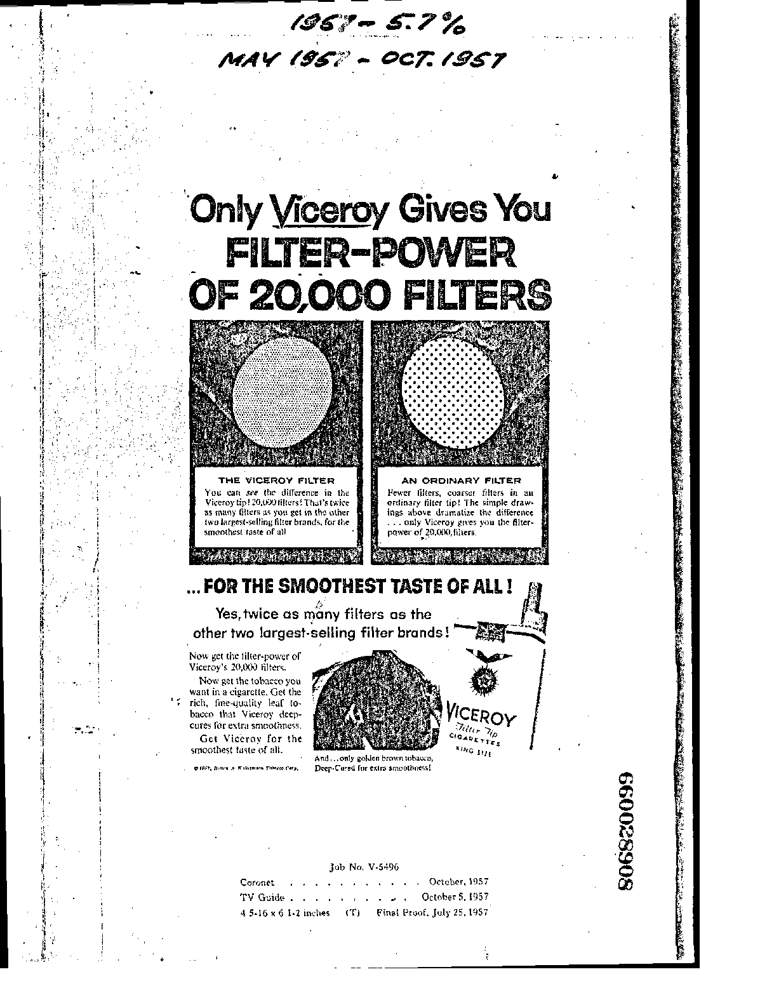

In [122]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from PIL import Image

img = Image.open('../../data/RVL_CDIP_one_example_per_class/advertisement/0000121291.tif')
img

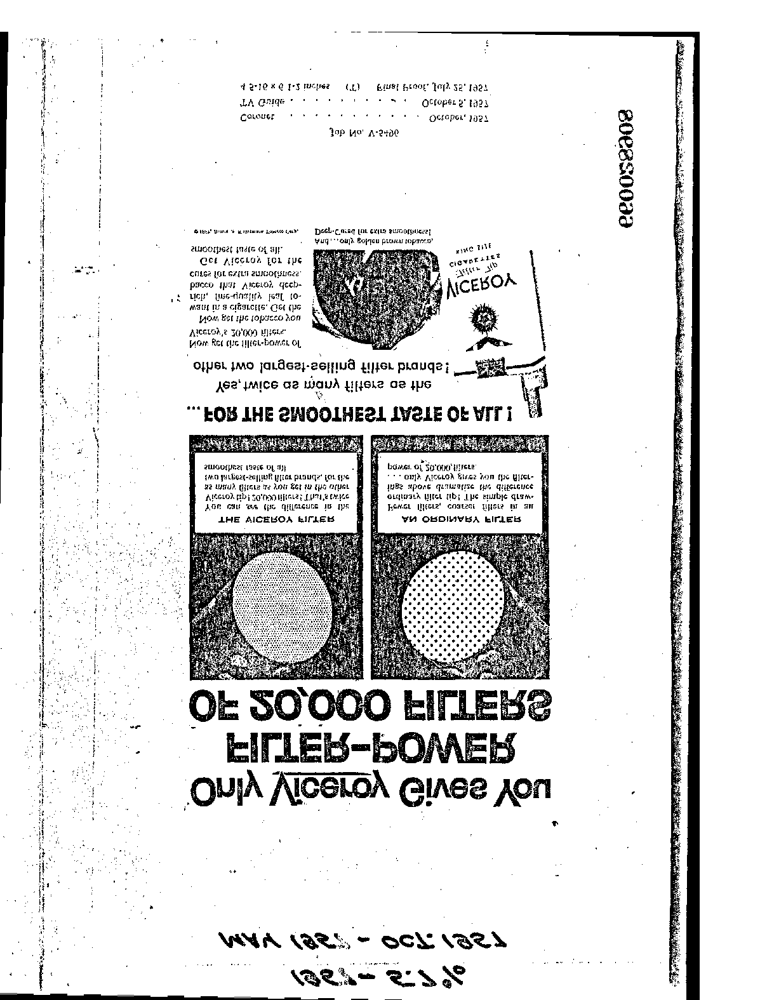

In [114]:
# 演示一些常用的图片增强操作
# 随机上下翻转
transforms.RandomVerticalFlip()(img) 
# 可输入概率值，若设为1，则必然反转
# transforms.RandomVerticalFlip(1)(img) 

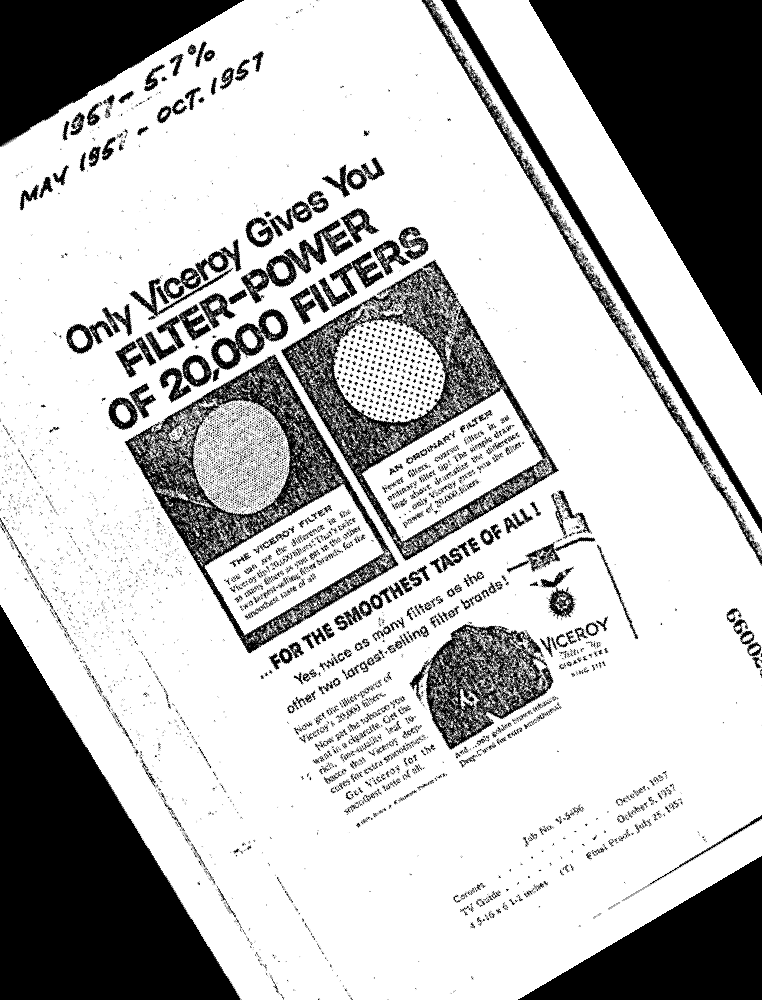

In [115]:
# 随机-45～45度内旋转
transforms.RandomRotation(45)(img)

In [116]:

transforms_train = transforms.Compose(
    [transforms.RandomRotation(45), # 随机-45～45度内旋转
    transforms.RandomVerticalFlip(), # 随机上下翻转
    transforms.RandomHorizontalFlip(), # 随机左右翻转
    transforms.ToTensor()] # 转化为torch.Tensor
)
transforms_val = transforms.Compose(
    [transforms.ToTensor()] # 即使是一个，也要有[],否则报错
)
# 或用下面
# transforms_val = transforms.ToTensor()


def target_transform(label):
    return torch.tensor(float(label))


# 根据图片目录创建数据集
ds_train = datasets.ImageFolder('../../data/RVL_CDIP_one_example_per_class', transform=transforms_train, target_transform=target_transform)
pprint(ds_train.class_to_idx)
ds_val = datasets.ImageFolder('../../data/RVL_CDIP_one_example_per_class', transform=transforms_val, target_transform=target_transform)
# use DataLoader to load dataset
dl_train = DataLoader(ds_train)
dl_val = DataLoader(ds_val)
for features, labels in dl_train:
    print(features.shape, labels.shape)
    break
for features, labels in dl_val:
    print(features.shape, labels.shape)
    break

{'advertisement': 0,
 'budget': 1,
 'email': 2,
 'file_folder': 3,
 'form': 4,
 'invoice': 5,
 'letter': 6,
 'memo': 7,
 'news_article': 8,
 'presentation': 9,
 'questionnaire': 10,
 'resume': 11,
 'scientific_publication': 12,
 'scientific_report': 13,
 'specification': 14}
torch.Size([1, 3, 1000, 762]) torch.Size([1])
torch.Size([1, 3, 1000, 762]) torch.Size([1])


#### **3，创建自定义数据集**

下面我们通过另外一种方式，即继承 torch.utils.data.Dataset 创建自定义数据集的方式来对 cifar2构建 数据管道。


In [117]:
from pathlib import Path
from PIL import Image

class DummyDataset(Dataset):
    def __init__(self, data_dir: str, transforms: transforms):
        self.paths_l = list(Path(data_dir).rglob('*.tif'))
        self.transforms = transforms
        print(f"self.paths_l: {self.paths_l}")

    def __len__(self):
        return len(self.paths_l)
    
    def __getitem__(self, idx):
        image = Image.open(str(self.paths_l[idx]))
        image = self.transforms(image)
        label = torch.Tensor(1) if 'form' in str(self.paths_l[idx]) else torch.Tensor(0)
        return image, label
        
data_dir = '../../data/RVL_CDIP_one_example_per_class'
# list(Path(data_dir).rglob('*.tif'))
print(list(Path(data_dir).rglob('*.tif')))
# 定义图片增强
transforms_train = transforms.Compose(
    [transforms.RandomRotation(45), 
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((225, 225)), # must resize image when the images sizes are different.
    transforms.ToTensor()]
) 
ds_train = DummyDataset('../../data/RVL_CDIP_one_example_per_class', transforms_train)
dl_train = DataLoader(ds_train, batch_size=4, shuffle=True)
for features, labels in dl_train:
    print(
        features.shape, labels.shape
    )
    break


[PosixPath('../../data/RVL_CDIP_one_example_per_class/form/00043194.tif'), PosixPath('../../data/RVL_CDIP_one_example_per_class/news_article/0000009966.tif'), PosixPath('../../data/RVL_CDIP_one_example_per_class/resume/0000157402.tif'), PosixPath('../../data/RVL_CDIP_one_example_per_class/letter/0000000700.tif'), PosixPath('../../data/RVL_CDIP_one_example_per_class/specification/0000011368.tif'), PosixPath('../../data/RVL_CDIP_one_example_per_class/questionnaire/0000002206.tif'), PosixPath('../../data/RVL_CDIP_one_example_per_class/memo/0000021894.tif'), PosixPath('../../data/RVL_CDIP_one_example_per_class/scientific_report/00060713.tif'), PosixPath('../../data/RVL_CDIP_one_example_per_class/scientific_publication/00265263_00265269.tif'), PosixPath('../../data/RVL_CDIP_one_example_per_class/file_folder/0000319200.tif'), PosixPath('../../data/RVL_CDIP_one_example_per_class/advertisement/0000121291.tif'), PosixPath('../../data/RVL_CDIP_one_example_per_class/presentation/0000076169.tif'),

### 三，使用DataLoader加载数据集

DataLoader能够控制batch的大小，batch中元素的采样方法，以及将batch结果整理成模型所需输入形式的方法，并且能够使用多进程读取数据。

DataLoader的函数签名如下。

```python
DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    sampler=None,
    batch_sampler=None,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
    drop_last=False,
    timeout=0,
    worker_init_fn=None,
    multiprocessing_context=None,
)
```


一般情况下，我们仅仅会配置 dataset, batch_size, shuffle, num_workers,pin_memory, drop_last这六个参数，

有时候对于一些复杂结构的数据集，还需要自定义collate_fn函数，其他参数一般使用默认值即可。

DataLoader除了可以加载我们前面讲的 torch.utils.data.Dataset 外，还能够加载另外一种数据集 torch.utils.data.IterableDataset。

和Dataset数据集相当于一种列表结构不同，IterableDataset相当于一种迭代器结构。 它更加复杂，一般较少使用。

- dataset : 数据集
- batch_size: 批次大小
- shuffle: 是否乱序
- sampler: 样本采样函数，一般无需设置。
- batch_sampler: 批次采样函数，一般无需设置。
- num_workers: 使用多进程读取数据，设置的进程数。
- collate_fn: 整理一个批次数据的函数。
- pin_memory: 是否设置为锁业内存。默认为False，锁业内存不会使用虚拟内存(硬盘)，从锁业内存拷贝到GPU上速度会更快。
- drop_last: 是否丢弃最后一个样本数量不足batch_size批次数据。
- timeout: 加载一个数据批次的最长等待时间，一般无需设置。
- worker_init_fn: 每个worker中dataset的初始化函数，常用于 IterableDataset。一般不使用。



In [118]:
ds = TensorDataset(torch.arange(50))
dl = DataLoader(
    ds,
    batch_size=11,
    shuffle=True,
    num_workers=2,
    drop_last=False
)
for i in dl:
    print(i) # i is a batch

[tensor([17, 41, 26, 46, 49,  0, 12, 42, 21, 15,  9])]
[tensor([11,  8, 45,  5, 23, 31, 30, 20, 13, 44, 40])]
[tensor([29, 27, 43, 37, 35, 18, 47, 38, 16, 24, 25])]
[tensor([ 2, 32, 22,  4, 33, 36, 14,  3, 39,  1, 19])]
[tensor([10, 48, 34, 28,  6,  7])]


参考文档： https://www.heywhale.com/mw/project/5f33d5c0af3980002cb83cfa